<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/ModelInterpretability_LIME_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIME

Lime is a general framework that aims to make the predictions of ‘any’ machine learning model more interpretable.

LIME provides local model interpretability. LIME modifies a single data sample by tweaking the feature values and observes the resulting impact on the output. Often, this is also related to what humans are interested in when observing the output of a model. The most common question is probably: why was this prediction made or which variables caused the prediction?

GITHUB: https://github.com/marcotcr/lime

ADAPTED FROM: https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b

## INSTALLATION

In [0]:
pip install lime

## EXAMPLE OF USAGE

### GENERATE MODEL

In [0]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.utils import shuffle
from __future__ import print_function
from io import StringIO
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

* **Fetch data**

In [0]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


Clean the data

In [0]:
# Remove entries with null tags 
df = df[pd.notnull(df['tags'])]

# Get a fraction of the entries
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)

# Randomize the values
df = shuffle(df, random_state=22)
df = df.reset_index(drop=True)

# Create a label column from the tags column
df['class_label'] = df['tags'].factorize()[0]

print(f'Number of labelled examples : {len(df)}')
df.head()

Number of labelled examples : 20000


,post,tags,class_label
0,how do i move something in rails i m a progr...,ruby-on-rails,0
1,c# how to output specific array searches t...,c#,1
2,integer.parseint and string format with decima...,java,2
3,compilation problem while upgrading a website ...,.net,3
4,query to list out the records by comparing max...,sql,4


Get labels

In [0]:
class_label_df = df[['tags', 'class_label']].drop_duplicates().sort_values('class_label')
label_to_id = dict(class_label_df.values)
id_to_label = dict(class_label_df[['class_label', 'tags']].values)

print('LABEL-CATEGORY List')
id_to_label

LABEL-CATEGORY List


{0: 'ruby-on-rails',
 1: 'c#',
 2: 'java',
 3: '.net',
 4: 'sql',
 5: 'objective-c',
 6: 'angularjs',
 7: 'asp.net',
 8: 'python',
 9: 'javascript',
 10: 'iphone',
 11: 'c',
 12: 'android',
 13: 'css',
 14: 'php',
 15: 'html',
 16: 'jquery',
 17: 'mysql',
 18: 'ios',
 19: 'c++'}

Clean text

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['post'] = df['post'].apply(clean_text)
print('Example of clean text :')
df['post'][0]

Example of clean text :


'how do i move something in rails   i m a programming noob  and learning rails i m making a gtd webapp for fun  and i d like  to make a  done  section in other words  i have a link that says  done  and i want that to move the current task into a done page  instead of indexhtmlerb all i know about rails is what was in the official beginner tutorial'

Final dataset

In [0]:
list_corpus = df["post"].tolist()
list_labels = df["class_label"].tolist()

assert len(list_corpus) == len(list_labels)

print(f'The length of the final list of examples is : {len(list_corpus)}')
print(f'Example :')
print(f'\t - LABEL : {list_labels[-1]}')
print(f'\t - TEXT : {list_corpus[-1]}')

The length of the final list of examples is : 20000
Example :
	 - LABEL : 17
	 - TEXT : database separation  mysql  i have a main mysql db set up  and a class to handle the queries to it it runs real nice i am building a custom advertising system on my site and i m wondering if there is any benefit to creating a separate database all together to handle that system     is there any pitfalls to doing it either way     option #1  one db for main website function  one db for advertising system    option #2  one db for both main website function and advertising system


* **Train model**

Split the dataset in training and evaluation data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

print(f'Number of training examples : {len(X_train)}')
print(f'Number of evaluation examples : {len(X_test)}')

Number of training examples : 16000
Number of evaluation examples : 4000


Text vectorization

In [0]:
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

Train a Logistic Regression model

In [0]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Evaluate the trained model

In [0]:
pred = logreg.predict(test_vectors)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.798, precision = 0.801, recall = 0.798, f1 = 0.799


### EXPLAINING PREDICTIONS USING SHAP

In [0]:
attrib_data = X_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 20
shap_vals = explainer.shap_values(X_test[:num_explanations])
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)
word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

In [0]:
attrib_data = X_train[:200]
num_explanations = 20

In [0]:
explainer = shap.DeepExplainer(logreg, attrib_data)

AssertionError: ignored

### EXPLAINING PREDICTIONS USING SHAP

In [0]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import shap

### GENERATE MODEL

* **Fetch data**

In [0]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


Clean the data

In [0]:
# Remove entries with null tags 
df = df[pd.notnull(df['tags'])]

# Get a fraction of the entries
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)

# Randomize the values
df = shuffle(df, random_state=22)
df = df.reset_index(drop=True)

# Create a label column from the tags column
df['class_label'] = df['tags'].factorize()[0]

print(f'Number of labelled examples : {len(df)}')
df.head()

Number of labelled examples : 20000


,post,tags,class_label
0,how do i move something in rails i m a progr...,ruby-on-rails,0
1,c# how to output specific array searches t...,c#,1
2,integer.parseint and string format with decima...,java,2
3,compilation problem while upgrading a website ...,.net,3
4,query to list out the records by comparing max...,sql,4


* **Prepare data**

  - *Labels*

Binarize the labels

In [0]:
tags_split = [tags.split(',') for tags in df['tags'].values]
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)

print(f'Labels by entry in a binary matrix of = ({tags_encoded.shape[0]} examples) X ({tags_encoded.shape[1]} labels)')
tags_encoded

Labels by entry in a binary matrix of = (20000 examples) X (20 labels)


array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
print(f'Classe labels: {tag_encoder.classes_}')

Classe labels: ['.net' 'android' 'angularjs' 'asp.net' 'c' 'c#' 'c++' 'css' 'html' 'ios'
 'iphone' 'java' 'javascript' 'jquery' 'mysql' 'objective-c' 'php'
 'python' 'ruby-on-rails' 'sql']


Get the binary labels matrix for the training and evaluation datasets

In [0]:
num_tags = len(tags_encoded[0])
train_size = int(len(df)*0.8)

print(f'Number of labels : {num_tags}')
print(f'Number of examples in the training dataset : {train_size}')

Number of labels : 20
Number of examples in the training dataset : 16000


In [0]:
y_train = tags_encoded[: train_size]
y_test = tags_encoded[train_size:]

print(f'Binarize Label for each training example - binary matrix of = ({y_train.shape[0]} training examples) X ({y_train.shape[1]} labels)')
print(f'Binarize Label for each evaluation example - binary matrix of = ({y_test.shape[0]} training examples) X ({y_test.shape[1]} labels)')

Binarize Label for each training example - binary matrix of = (16000 training examples) X (20 labels)
Binarize Label for each evaluation example - binary matrix of = (4000 training examples) X (20 labels)


 - *Text*

In [0]:
train_post = df['post'].values[:train_size]
test_post = df['post'].values[train_size:]

print(f'Number of training texts : {len(train_post)}')
print(f'Number of evaluation texts : {len(test_post)}')

Number of training texts : 16000
Number of evaluation texts : 4000


Tokenize the texts

In [0]:
class TextPreprocessor(object):
    # Class to contain text processor functionalities
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

In [0]:
# Instiate the Text Processor
VOCAB_SIZE = 500
processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_post)

In [0]:
# Get the tokenized version of the training and evaluation texts 
X_train = processor.transform_text(train_post)
X_test = processor.transform_text(test_post)

In [0]:
print(f'Training data expresed in a matrix of tokens of: ({X_train.shape[0]} examples) x ({X_train.shape[1]} tokens) ')
X_train

Training data expresed in a matrix of tokens of: (16000 examples) x (500 tokens) 


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [0]:
print(f'Training data expresed in a matrix of tokens of: ({X_test.shape[0]} examples) x ({X_test.shape[1]} tokens) ')
X_test

Training data expresed in a matrix of tokens of: (4000 examples) x (500 tokens) 


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

* **Train model**

In [0]:
def create_model(vocab_size, num_tags):
    # Create a keras sequential model

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, input_shape = (vocab_size,), activation='relu'))
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
    
# Create model
model = create_model(VOCAB_SIZE, num_tags)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Train model
model.fit(X_train, y_train, epochs = 2, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(model.evaluate(X_test, y_test, batch_size = 128)))

Train on 14400 samples, validate on 1600 samples
Epoch 1/2
14400/14400 [==============================] - 1s 39us/sample - loss: 0.3245 - acc: 0.8894 - val_loss: 0.1985 - val_acc: 0.9500
Epoch 2/2
4000/4000 [==============================] - 0s 13us/sample - loss: 0.1367 - acc: 0.9561
Eval loss/accuracy:[0.13668314325809477, 0.9560876]


### EXPLAINING PREDICTIONS USING SHAP

We use the first X training documents as our background data set to integrate over, and to create a SHAP explainer object.

In [0]:
attrib_data = X_train[:400]
explainer = shap.DeepExplainer(model, attrib_data)

We get the attribution values for individual predictions on a subset of the test set.

In [0]:
eval_data = X_test[:40]
shap_vals = explainer.shap_values(eval_data)

We get the feature names. In the NLP model the features are the words in the vocabulary. 

In [0]:
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)
word_lookup = [''] + word_lookup

print(f'Features size : {len(word_lookup)}')
print(f'List of words in the vocabulary: {word_lookup[0:20]} ...')

Features size : 79055
List of words in the vocabulary: ['', 'the', 'i', 'code', 'lt', 'gt', 'to', 'a', 'pre', 'in', 'is', 'and', 'this', 'of', '0', 'it', '1', 'for', 'if', 'id'] ...


Use SHAP’s `summary_plot` method to show the top features impacting model predictions.

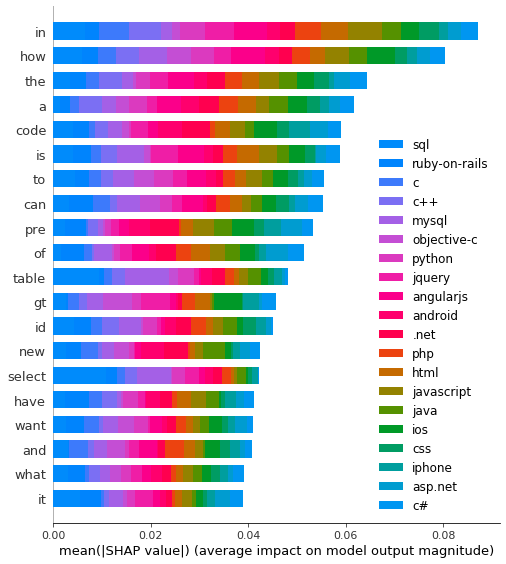

In [0]:
shap.summary_plot(
    # Explicability values
    shap_vals, 
    
    #Names for each feature
    feature_names=word_lookup, 

    #Names of the label classes
    class_names=tag_encoder.classes_)

* Each row is a signal word that contribute in the model.
* Longest rows are biggest signals used by the model. In the plot the signal words are represented in order of importance in the model. The first signal word in the plot (in this case 'in') is the biggest signal word used by the model. The second is the second, third ...
* Each color represent the contribution of the signal word to a specific category. In this case, the color in the word 'in' is bigger in `javascript` than in `python`. In this case, 'in' contribute more to `javascript` than to `python` predictions. 